In [33]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
# from google.colab import files

In [34]:
# from google.colab import drive
# drive.mount('/content/drive')
# dataset_path = '/content/drive/My Drive/dataset/sim_data.csv'
dataset_path = 'simulator_data.csv'
df = pd.read_csv(dataset_path)


In [37]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# Load the dataset

import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
import pandas as pd
import numpy as np

data = pd.read_csv(dataset_path)

# Function to compute the distance between two points
def calculate_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# Function to create a graph data object and NetworkX graph for a given timestamp
def create_graph_data_for_timestamp(df, timestamp):
    timestamp_data = df[df['timestamp'] == timestamp]
    vehicle_ids = timestamp_data['vehicleId'].unique()
    tower_ids = timestamp_data['towerId'].unique()
    vehicle_mapping = {vid: i for i, vid in enumerate(vehicle_ids)}
    tower_mapping = {tid: i + len(vehicle_ids) for i, tid in enumerate(tower_ids)}

    node_features = []
    edge_index = []
    edge_features = []

    G = nx.Graph()  # NetworkX Graph for visualization

    for vid in vehicle_ids:
        vehicle_data = timestamp_data[timestamp_data['vehicleId'] == vid].iloc[0]
        node_features.append([vehicle_data['vehicleSpeed'], vehicle_data['vehicleDirection'],
                              vehicle_data['signalQuality'], vehicle_data['vehiclePosX'],
                              vehicle_data['vehiclePosY']])
        G.add_node(vehicle_mapping[vid], pos=(vehicle_data['vehiclePosX'], vehicle_data['vehiclePosY']),
                   type='vehicle')

    for tid in tower_ids:
        tower_data = timestamp_data[timestamp_data['towerId'] == tid].iloc[0]
        node_features.append([tower_data['towerPosX'], tower_data['towerPosY']])
        G.add_node(tower_mapping[tid], pos=(tower_data['towerPosX'], tower_data['towerPosY']),
                   type='tower')

    for _, row in timestamp_data.iterrows():
        vehicle_id = vehicle_mapping[row['vehicleId']]
        tower_id = tower_mapping[row['towerId']]
        edge_index.append([vehicle_id, tower_id])
        edge_index.append([tower_id, vehicle_id])

        distance = calculate_distance(row['vehiclePosX'], row['vehiclePosY'],
                                      row['towerPosX'], row['towerPosY'])
        edge_features.append([row['signalQuality'], row['masterRssi'],
                              row['candidateMasterRssi'], distance])
        edge_features.append([row['signalQuality'], row['masterRssi'],
                              row['candidateMasterRssi'], distance])

        # Add edges to the NetworkX graph
        G.add_edge(vehicle_id, tower_id)


    node_features_tensor = torch.tensor(node_features, dtype=torch.float)
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_features_tensor = torch.tensor(edge_features, dtype=torch.float)

    # Ensure correct shapes
    node_features_tensor = node_features_tensor.view(-1, len(node_features[0]))
    edge_features_tensor = edge_features_tensor.view(-1, len(edge_features[0]))

    graph_data = Data(x=node_features_tensor, edge_index=edge_index_tensor, edge_attr=edge_features_tensor)

    # node_features_tensor = torch.tensor(node_features, dtype=torch.float)
    # edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    # edge_features_tensor = torch.tensor(edge_features, dtype=torch.float)

    # graph_data = Data(x=node_features_tensor, edge_index=edge_index_tensor, edge_attr=edge_features_tensor)

    return graph_data, G

# Visualization function
def visualize_graph(G):
    pos = nx.get_node_attributes(G, 'pos')
    types = nx.get_node_attributes(G, 'type')

    # Draw vehicles and towers with different colors
    nx.draw(G, pos, with_labels=True,
            node_color=[('skyblue' if types[node] == 'vehicle' else 'lightgreen') for node in G],
            edge_color='gray', node_size=500)

# Example: Create a graph data object and NetworkX graph for the first timestamp
first_timestamp = data['timestamp'].min()
graph_data, G = create_graph_data_for_timestamp(data, first_timestamp)

# Visualize the graph
plt.figure(figsize=(12, 8))
visualize_graph(G)
plt.show()



ValueError: expected sequence of length 5 at dim 1 (got 2)

In [26]:
import math

# Define a function to calculate the distance between two points
def calculate_distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# Apply the function to each row of the dataframe and assign the result to a new column
df["masterDistance"] = df.apply(lambda row: calculate_distance(row["masterPosX"], row["masterPosY"], row["vehiclePosX"], row["vehiclePosY"]), axis=1)

In [6]:
df

,timestamp,vehicleId,towerId,masterId,candidateMasterId,signalQuality,masterRssi,candidateMasterRssi,hysteresisTh,handover,...,masterDistance,vehiclePosX,vehiclePosY,towerPosX,towerPosY,masterPosX,masterPosY,vehicleSpeed,vehicleDirection,numVehicles
0,0.5,2065,1,1,1,29.8193,29.8193,29.8193,-2.01807,NO,...,923.985732,1571.61,1597.49,834,1041,834,1041,0.000000,1,1
1,0.5,2067,2,2,2,31.7796,31.7796,31.7796,-1.82204,NO,...,583.231466,2650.52,1717.39,2496,1155,2496,1155,0.338914,1,2
2,0.5,2075,2,2,2,34.7370,34.7370,34.7370,-1.52630,NO,...,239.168475,2461.52,1391.67,2496,1155,2496,1155,3.329740,1,3
3,0.5,2070,3,3,3,35.8649,35.8649,35.8649,-1.41351,NO,...,811.312188,3496.78,1310.76,4293,1155,4293,1155,47.017500,1,4
4,0.5,2073,3,3,3,15.9026,15.9026,15.9026,-3.40974,NO,...,607.664222,3728.55,1380.06,4293,1155,4293,1155,60.599900,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35753,101.0,2136,9,8,8,24.5195,28.1486,28.1486,-2.18514,NO,...,589.924405,2834.62,2983.14,3162,3672,2391,3372,199.185000,9,100
35754,101.0,2144,9,6,6,30.6821,35.3448,35.3448,-1.46552,NO,...,683.855831,3038.67,2824.41,3162,3672,3566,2389,1071.010000,9,100
35755,101.0,2058,10,9,9,29.2850,35.4253,35.4253,-1.45747,NO,...,578.287428,3539.97,3234.33,4393,2995,3162,3672,93.667600,6,100
35756,101.0,2087,10,9,9,20.1538,26.5872,26.5872,-2.34128,NO,...,579.539517,3514.54,3212.02,4393,2995,3162,3672,0.000000,6,100


Preprocess the data


In [28]:
import torch
from torch_geometric.data import Data
import pandas as pd


# Filter the DataFrame for a specific timestamp, e.g., timestamp 6
timestamp = 2
df_timestamp = df[df['timestamp'] == timestamp]

# Extract vehicle features
vehicle_features = df_timestamp[['vehicleId', 'vehiclePosX', 'vehiclePosY', 'vehicleSpeed', 'vehicleDirection']]
vehicle_features = vehicle_features.drop_duplicates(subset=['vehicleId'])

# Extract tower features
tower_features = df_timestamp[['masterId','masterLoad' ,'masterPosX', 'masterPosY', 'masterDistance']]
tower_features = tower_features.drop_duplicates(subset=['masterId'])

# Calculate the number of dummy features needed
# The number of vehicle features is the number of columns minus the 'vehicleId' column
num_vehicle_features = vehicle_features.shape[1] - 1  # minus 1 for 'vehicleId' column
num_tower_features = tower_features.shape[1] - 1  # minus 1 for 'towerId' column
dummy_feature_count = num_vehicle_features - num_tower_features


# Convert vehicle and tower features to tensor
tower_tensor = torch.tensor(tower_features.iloc[:, 1:].values, dtype=torch.float)
vehicle_tensor = torch.tensor(vehicle_features.iloc[:, 1:].values, dtype=torch.float)


# Concatenate vehicle and tower features for node features
node_features = torch.cat([vehicle_tensor, tower_tensor], dim=0)

# Create a mapping from vehicle IDs and tower IDs to indices
vehicle_id_to_index = {vid: i for i, vid in enumerate(vehicle_features['vehicleId'])}
tower_id_to_index = {tid: i + len(vehicle_id_to_index) for i, tid in enumerate(tower_features['masterId'])}

# Construct edge index
edge_index = [[], []]

for _, row in df_timestamp.iterrows():
    vehicle_idx = vehicle_id_to_index[row['vehicleId']]
    tower_idx = tower_id_to_index[row['masterId']]  # Use MasterId to connect vehicles
    edge_index[0].append(vehicle_idx)
    edge_index[1].append(tower_idx)

edge_index = torch.tensor(edge_index, dtype=torch.long)

# Create the graph data object without edge features for now
data = Data(x=node_features, edge_index=edge_index)

num_node_features = node_features.shape[1]
print("Number of node features:", num_node_features)
print("Edge index shape:", edge_index.shape)
print("Node features shape:", node_features.shape)

Number of node features: 4
Edge index shape: torch.Size([2, 182])
Node features shape: torch.Size([108, 4])


Visualize the Graph architecture

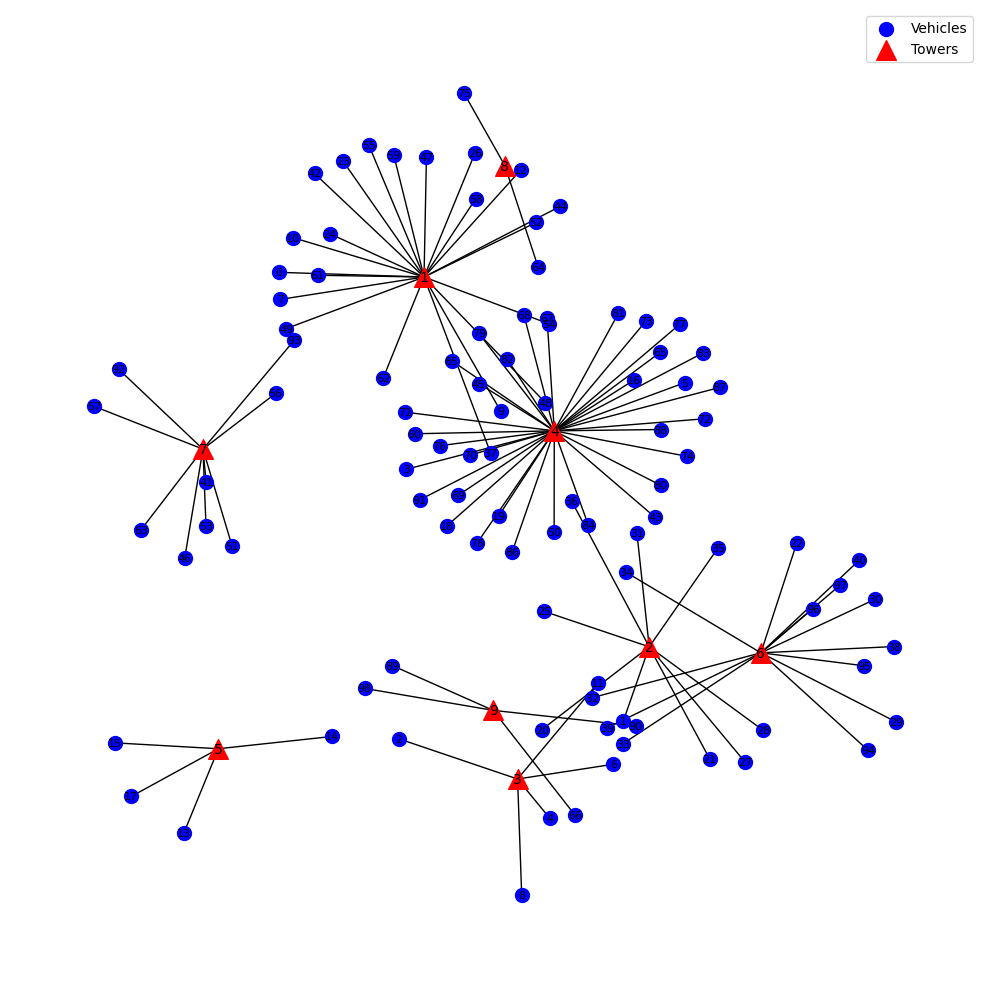

In [29]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(edge_index, node_features, num_vehicle_nodes, edge_labels=None):
    G = nx.Graph()

    # Add nodes
    for i in range(node_features.shape[0]):
        G.add_node(i)

    # Add edges
    for i in range(edge_index.shape[1]):
        src, dest = edge_index[:, i]
        G.add_edge(int(src), int(dest))

    # Compute positions for all nodes using spring layout
    pos = nx.spring_layout(G, k=0.15, iterations=20)  # Adjust k for distance between nodes

    plt.figure(figsize=(10, 10))  # Set up the plot size

    # Draw vehicle nodes with 'o' shape
    vehicle_nodes = range(num_vehicle_nodes)
    nx.draw_networkx_nodes(G, pos, nodelist=vehicle_nodes, node_color='blue', node_size=100, label='Vehicles', node_shape='o')

    # Draw tower nodes with '^' shape
    tower_nodes = range(num_vehicle_nodes, node_features.shape[0])
    nx.draw_networkx_nodes(G, pos, nodelist=tower_nodes, node_color='red', node_size=200, label='Towers', node_shape='^')

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1)

    # Draw node labels for vehicles
    vehicle_labels = {i: str(i) for i in vehicle_nodes}
    nx.draw_networkx_labels(G, pos, labels=vehicle_labels, font_size=8)

    # Draw node labels for towers with a label constraint of 1-10
    tower_labels = {i: i-num_vehicle_nodes+1 if i-num_vehicle_nodes < 10 else ''
                    for i in tower_nodes}
    nx.draw_networkx_labels(G, pos, labels=tower_labels, font_size=10)

    # Optionally draw edge labels
    if edge_labels:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.legend()
    plt.axis("off")
    plt.tight_layout()  # Adjust the padding between and around subplots
    plt.show()

# Number of vehicle nodes (adjust this based on your data)
num_vehicle_nodes = 99  # Replace with the actual number of vehicle nodes

# Visualize the graph
visualize_graph(data.edge_index, data.x, num_vehicle_nodes)


GNN Model Architecture

In [48]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class CandidateGNN(torch.nn.Module):
    def __init__(self, num_node_features, num_output_features):
        super(CandidateGNN, self).__init__()
        # Define the layers
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_output_features)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # Apply graph convolutions
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = self.conv2(x, edge_index, edge_attr)

        return x

# num_output_features is 1 if you're just scoring towers, more if you have multiple criteria
model = CandidateGNN(num_node_features, num_output_features=1)


# Assuming num_node_features and num_classes are defined

model_output = model(data)


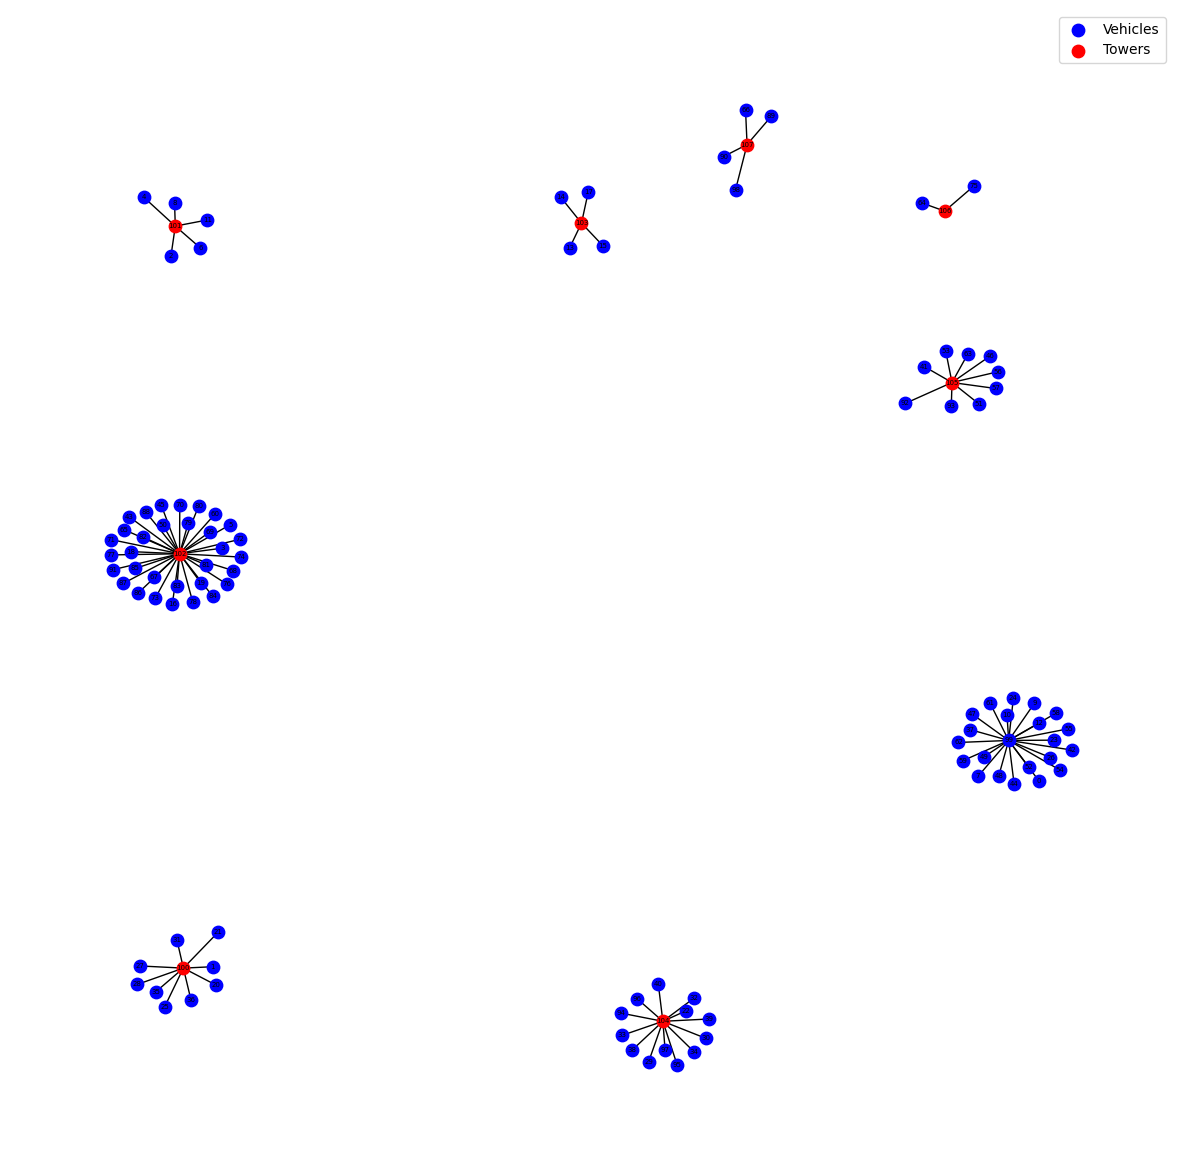

In [63]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(edge_index, node_features, num_vehicle_nodes, edge_labels=None):
    G = nx.Graph()

    # Add nodes
    for i in range(node_features.shape[0]):
        G.add_node(i)

    # Add edges
    for i in range(edge_index.shape[1]):
        src, dest = edge_index[:, i]
        G.add_edge(int(src), int(dest))

    pos = nx.spring_layout(G)  # positions for all nodes

    # Set up the plot size
    plt.figure(figsize=(15, 15))  # You can adjust the size as needed

    # nodes
    vehicle_nodes = range(num_vehicle_nodes)
    tower_nodes = range(num_vehicle_nodes, node_features.shape[0])

    nx.draw_networkx_nodes(G, pos, nodelist=vehicle_nodes, node_color='blue', node_size=80, label='Vehicles')
    nx.draw_networkx_nodes(G, pos, nodelist=tower_nodes, node_color='red', node_size=80, label='Towers')

    # edges
    nx.draw_networkx_edges(G, pos, width=1)

    # node labels
    nx.draw_networkx_labels(G, pos, font_size=5, font_family="sans-serif")

    # edge labels
    if edge_labels:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.legend()
    plt.axis("off")
    plt.show()

# Number of vehicle nodes (adjust this based on your data)
num_vehicle_nodes = 100  # replace with the actual number of vehicle nodes

# Visualize the graph
visualize_graph(data.edge_index, data.x, num_vehicle_nodes)
